# Compute and plot contrast tuning curves
### This notebook uses the extracted event times to calculate the tuning of individual neurons to contrast X direction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pynwb

import warnings

In [2]:
from dandi.dandiapi import DandiAPIClient

In [3]:
savepath = 'data/'

## Specify a session to analyze and load NWB file

In [4]:
session_ID = 682746585

In [5]:
dandiset_id = '000039'
filepath = 'sub-661968859/sub-661968859_ses-682746585_behavior+ophys.nwb' 
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

## Functions to load specific data assets from the nwb file

In [6]:
def load_sweep_table(s3_url):
    '''Creates a dataframe of the stimulus presentation table'''
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with pynwb.NWBHDF5IO(s3_url, mode='r', load_namespaces=True, driver='ros3') as io:
            nwbfile = io.read()
            start_times = np.array(nwbfile.intervals['epochs']['start_time'].data)
            stop_times = np.array(nwbfile.intervals['epochs']['stop_time'].data)
            contrasts = np.array(nwbfile.intervals['epochs']['contrast'].data)
            directions = np.array(nwbfile.intervals['epochs']['direction'].data)
            SFs = np.array(nwbfile.intervals['epochs']['spatial_frequency'].data)
            TFs = np.array(nwbfile.intervals['epochs']['temporal_frequency'].data)

    df = pd.DataFrame(np.zeros((len(start_times),6)),columns=('Start','End','Contrast','Ori','SF','TF'))
    df['Start'] = start_times
    df['End'] = stop_times
    df['Contrast'] = contrasts
    df['Ori'] = directions
    df['SF'] = SFs
    df['TF'] = TFs
    return df

In [7]:
sweep_table = load_sweep_table(s3_url)

In [8]:
sweep_table.head()

,Start,End,Contrast,Ori,SF,TF
0,194.0,254.0,0.05,270.0,0.04,1.0
1,284.0,344.0,0.05,270.0,0.04,1.0
2,375.0,435.0,0.10,45.0,0.04,1.0
3,465.0,525.0,0.80,0.0,0.04,1.0
4,556.0,616.0,0.60,135.0,0.04,1.0


This dataframe describes the stimulus presentation trials. The Start and End times are given in imaging frames (at 30 frames/sec). So you can see each trial has a duration of 2 seconds, with 1 second between trials, when mean luminance gray is presented. There are 8 directions ("Ori") of gratings and 6 Contrasts, and there are blanksweeps interleaved when Contrast, Ori, SF, TF are all NaN.

In [9]:
def grating_params(sweep_table):
    '''Extracts the grating parameters from the stimulus presentation table'''
    directions = np.sort(sweep_table.Ori.dropna().unique()).astype(int)
    contrasts = np.sort(sweep_table.Contrast.dropna().unique())
    
    return directions, contrasts

In [10]:
def load_mean_sweep_events(s3_url, savepath):
    '''Computes (or loads if already saved) an array of the mean events per neuron during each stimulus presentation'''
    if os.path.isfile(os.path.join(savepath, str(session_ID)+'_mean_sweep_events.npy')):
        mse = np.load(os.path.join(savepath, str(session_ID)+'_mean_sweep_events.npy'))
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            with pynwb.NWBHDF5IO(s3_url, mode='r', load_namespaces=True, driver='ros3') as io:
                nwbfile = io.read()
                events = np.array(nwbfile.processing['brain_observatory_pipeline']['l0_events']['true_false_events'].data)
                sweep_table = load_sweep_table(s3_url)

                num_neurons = np.shape(events)[1]
                num_sweeps = len(sweep_table)

                mse = np.zeros((num_sweeps,num_neurons))
                for sweep in range(num_sweeps):
                    start_frame = int(sweep_table['Start'][sweep])
                    end_frame = int(sweep_table['End'][sweep])
                    mse[sweep] = np.mean(events[start_frame:end_frame,:],axis=0)
                os.makedirs(savepath, exist_ok=True)
                np.save(os.path.join(savepath, str(session_ID)+'_mean_sweep_events.npy'),mse)
    
    return mse

## Functions to compute tuning curve and identify peak conditions for all neurons in session

In [11]:
def compute_mean_condition_responses(sweep_table, mean_sweep_events):
    '''Computes the mean response and SEM to each stimulus condition (i.e. each direction/contrast combination) 
    and for the blank sweeps (contrast=0)'''
    
    (num_sweeps,num_cells) = np.shape(mean_sweep_events) 
    
    directions, contrasts = grating_params(sweep_table)
    
    condition_responses = np.zeros((num_cells,len(directions),len(contrasts)))
    condition_sem = np.zeros((num_cells,len(directions),len(contrasts)))
    for i_dir,direction in enumerate(directions):
        is_direction = sweep_table['Ori'] == direction
        for i_con,contrast in enumerate(contrasts):
            is_contrast = sweep_table['Contrast'] == contrast
            is_condition = (is_direction & is_contrast).values
            
            condition_responses[:,i_dir,i_con] = np.mean(mean_sweep_events[is_condition],axis=0)
            condition_sem[:,i_dir,i_con] = np.std(mean_sweep_events[is_condition],axis=0)/np.sqrt(float(is_condition.sum()))
            
    is_blank = np.isnan(sweep_table['Ori'].values)
    blank_sweep_responses = np.mean(mean_sweep_events[is_blank],axis=0)
    blank_sweep_sem = np.std(mean_sweep_events[is_blank],axis=0)/np.sqrt(float(is_blank.sum()))
            
    return condition_responses, condition_sem, blank_sweep_responses, blank_sweep_sem

In [12]:
def get_peak_conditions(condition_responses):
    
    (num_cells,num_directions,num_contrasts) = np.shape(condition_responses)
    
    peak_direction = np.zeros((num_cells,),dtype=np.uint8)
    peak_contrast = np.zeros((num_cells,),dtype=np.uint8)
    for nc in range(num_cells):
        cell_max = np.nanmax(condition_responses[nc])
        is_max = condition_responses[nc] == cell_max
        
        if is_max.sum()==1:
            (direction,contrast) = np.argwhere(is_max)[0,:]
        else:
            print(str(is_max.sum())+' peaks')
            r = np.random.choice(is_max.sum())
            (direction,contrast) = np.argwhere(is_max)
            print(np.shape(direction))
            direction = direction[r]
            contrast = contrast[r]
        peak_direction[nc] = direction
        peak_contrast[nc] = contrast
        
    return peak_direction, peak_contrast

## Plot tuning curve for one cell

In [13]:
def plot_single_cell_tuning_curves(savepath,example_cell):
    
    mse = 3000.0*load_mean_sweep_events(s3_url, savepath)
    sweep_table = load_sweep_table(s3_url)
    directions, contrasts = grating_params(sweep_table)

    condition_resp, condition_SEM, blank_responses, _ = compute_mean_condition_responses(sweep_table,mse)
    
    #shift zero to center:
    # directions = [-135,-90,-45,0,45,90,135,180]
    # condition_resp = cu.center_direction_zero(condition_responses)
    # condition_SEM = cu.center_direction_zero(condition_SEM)
    
    #full direction by contrast response heatmap
    plt.figure(figsize=(7,4))
    ax = plt.subplot2grid((5,5),(0,3),rowspan=5,colspan=2)
    im = ax.imshow(condition_resp[example_cell],vmin=0.0,interpolation='nearest',aspect='auto',cmap='plasma')
    ax.set_ylabel('Direction (deg)',fontsize=12)
    ax.set_xlabel('Contrast (%)',fontsize=12)
    ax.set_xticks(np.arange(len(contrasts)))
    ax.set_xticklabels([str(int(100*x)) for x in contrasts],fontsize=12)
    ax.set_yticks(np.arange(len(directions)))
    ax.set_yticklabels([str(x) for x in directions],fontsize=12)  
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label('Event magnitude per second (%)',fontsize=12)
    
    
    peak_dir_idx, peak_con_idx = get_peak_conditions(condition_resp)
    
    #contrast tuning at peak direction
    contrast_means = condition_resp[example_cell,peak_dir_idx[example_cell],:]
    contrast_SEMs = condition_SEM[example_cell,peak_dir_idx[example_cell],:]
    
    y_max = 1.1*np.max(contrast_means+contrast_SEMs)
    
    ax = plt.subplot2grid((5,5),(0,0),rowspan=2,colspan=2)
    ax.errorbar(np.log(contrasts),contrast_means,contrast_SEMs,linewidth=0.7,color='b')
    ax.plot([np.log(contrasts[0]),np.log(contrasts[-1])],[blank_responses[example_cell],blank_responses[example_cell]],linewidth=0.7,linestyle='--',color='b')
    ax.set_xticks(np.log(contrasts))
    ax.set_xticklabels([str(int(100*x)) for x in contrasts],fontsize=12)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_xlabel('Contrast (%)',fontsize=12)
    ax.set_ylabel('Event magnitude per second (%)  ',fontsize=12)
    ax.set_ylim([0,y_max])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('@ '+str(directions[peak_dir_idx[example_cell]])+' degrees',fontsize=12)

    #direction tuning at peak contrast
    direction_means = condition_resp[example_cell,:,peak_con_idx[example_cell]]
    direction_SEMs = condition_SEM[example_cell,:,peak_con_idx[example_cell]]
    ax = plt.subplot2grid((5,5),(3,0),rowspan=2,colspan=2)
    ax.errorbar(np.arange(len(directions)),direction_means,direction_SEMs,linewidth=0.7,color='b')
    ax.plot([0,len(directions)-1],[blank_responses[example_cell],blank_responses[example_cell]],linestyle='--',color='b',linewidth=0.7)
    ax.set_xlim(-0.07,7.07)
    ax.set_xticks(np.arange(len(directions)))
    ax.set_xticklabels([str(x) for x in directions],fontsize=12)
    ax.tick_params(axis='y',labelsize=12)
    
    ax.set_xlabel('Direction (deg)',fontsize=12)
    #ax.set_ylabel('Response',fontsize=14)
    ax.set_ylim([0,y_max])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('@ '+str(int(100*contrasts[peak_con_idx[example_cell]]))+'% contrast',fontsize=12)
    
    
    plt.tight_layout(w_pad=-5.5, h_pad=0.1)
    
    os.makedirs('figures', exist_ok=True)
    plt.savefig(os.path.join('figures',str(session_ID)+'_cell_'+str(example_cell)+'_tuning_curves.png'),dpi=300)
    plt.show()
    plt.close()

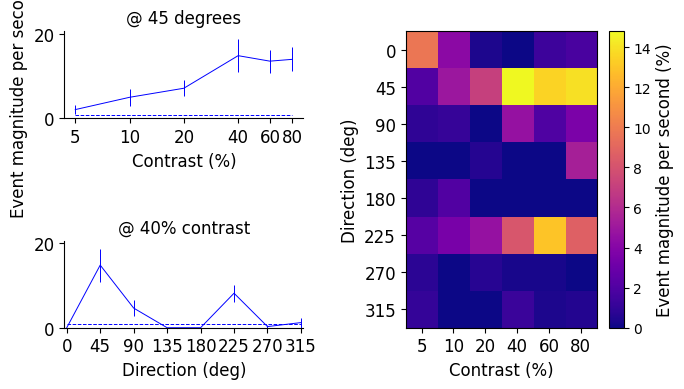

In [14]:
plot_single_cell_tuning_curves(savepath, 6)